In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import FeatureHasher
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
import copy

In [3]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sample = pd.read_csv('../input/sample_submission.csv')

In [4]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


In [5]:
test.head()

,id,molecule_name,atom_index_0,atom_index_1,type
0,4658147,dsgdb9nsd_000004,2,0,2JHC
1,4658148,dsgdb9nsd_000004,2,1,1JHC
2,4658149,dsgdb9nsd_000004,2,3,3JHH
3,4658150,dsgdb9nsd_000004,3,0,1JHC
4,4658151,dsgdb9nsd_000004,3,1,2JHC


In [6]:
train.shape, test.shape

((4658147, 6), (2505542, 5))

In [7]:
train.dtypes

id                            int64
molecule_name                object
atom_index_0                  int64
atom_index_1                  int64
type                         object
scalar_coupling_constant    float64
dtype: object

In [8]:
test.dtypes

id                int64
molecule_name    object
atom_index_0      int64
atom_index_1      int64
type             object
dtype: object

In [9]:
train.describe()

,id,atom_index_0,atom_index_1,scalar_coupling_constant
count,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06
mean,2.329073e+06,1.335689e+01,5.883966e+00,1.592165e+01
std,1.344691e+06,3.267712e+00,4.993943e+00,3.494198e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-3.621860e+01
25%,1.164536e+06,1.100000e+01,2.000000e+00,-2.549780e-01
50%,2.329073e+06,1.300000e+01,5.000000e+00,2.281130e+00
75%,3.493610e+06,1.600000e+01,8.000000e+00,7.390655e+00
max,4.658146e+06,2.800000e+01,2.800000e+01,2.048800e+02


In [10]:
Q1_atmo0_train = train['atom_index_0'].quantile(0.25)
Q3_atmo0_train = train['atom_index_0'].quantile(0.75)
IQR_atom0_train = Q3_atmo0_train - Q1_atmo0_train
upper_atom0_train = Q3_atmo0_train + 1.5 * IQR_atom0_train
lower_atom0_train = Q1_atmo0_train - 1.5 * IQR_atom0_train
upper_atom0_train, lower_atom0_train

(23.5, 3.5)

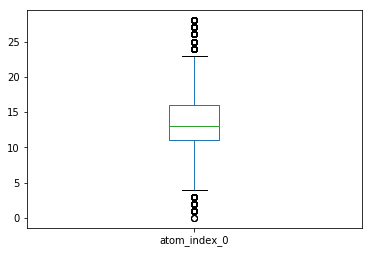

In [11]:
train['atom_index_0'].plot.box()

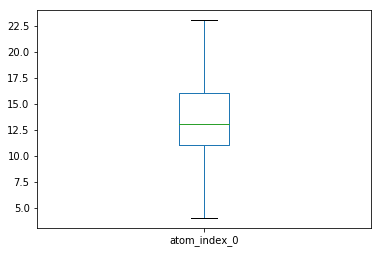

In [12]:
train.loc[train['atom_index_0'] > upper_atom0_train ,'atom_index_0'] = np.median(train['atom_index_0'])
train.loc[train['atom_index_0'] < lower_atom0_train ,'atom_index_0'] = np.median(train['atom_index_0'])
train['atom_index_0'].plot.box()

In [13]:
Q1_atmo0_test = test['atom_index_0'].quantile(0.25)
Q3_atmo0_test = test['atom_index_0'].quantile(0.75)
IQR_atom0_test = Q3_atmo0_test - Q1_atmo0_test
upper_atom0_test = Q3_atmo0_test + 1.5 * IQR_atom0_test
lower_atom0_test = Q1_atmo0_test - 1.5 * IQR_atom0_test
upper_atom0_test, lower_atom0_test

(23.5, 3.5)

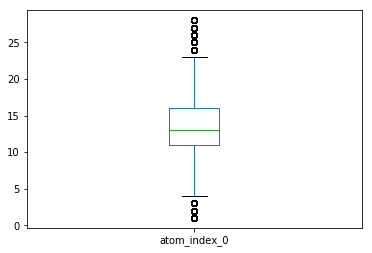

In [14]:
test['atom_index_0'].plot.box()

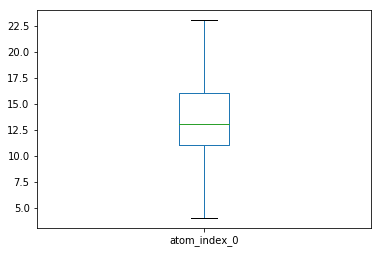

In [15]:
test.loc[test['atom_index_0'] > upper_atom0_test ,'atom_index_0'] = np.median(test['atom_index_0'])
test.loc[test['atom_index_0'] < lower_atom0_test ,'atom_index_0'] = np.median(test['atom_index_0'])
test['atom_index_0'].plot.box()

In [16]:
Q1_atmo1_train = train['atom_index_1'].quantile(0.25)
Q3_atmo1_train = train['atom_index_1'].quantile(0.75)
IQR_atom1_train = Q3_atmo1_train - Q1_atmo1_train
upper_atom1_train = Q3_atmo1_train + 1.5 * IQR_atom1_train
lower_atom1_train = Q1_atmo1_train - 1.5 * IQR_atom1_train
upper_atom1_train, lower_atom1_train

(17.0, -7.0)

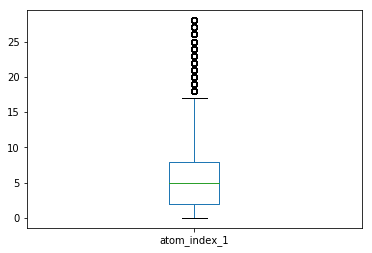

In [17]:
train['atom_index_1'].plot.box()

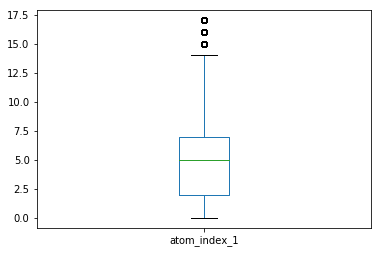

In [18]:
train.loc[train['atom_index_1'] > upper_atom1_train ,'atom_index_1'] = np.median(train['atom_index_1'])
train.loc[train['atom_index_1'] < lower_atom1_train ,'atom_index_1'] = np.median(train['atom_index_1'])
train['atom_index_1'].plot.box()

In [19]:
Q1_atmo1_test = test['atom_index_1'].quantile(0.25)
Q3_atmo1_test = test['atom_index_1'].quantile(0.75)
IQR_atom1_test = Q3_atmo1_test - Q1_atmo1_test
upper_atom1_test = Q3_atmo1_test + 1.5 * IQR_atom1_test
lower_atom1_test = Q1_atmo1_test - 1.5 * IQR_atom1_test
upper_atom1_test, lower_atom1_test

(17.0, -7.0)

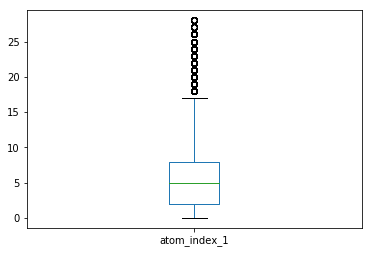

In [20]:
test['atom_index_1'].plot.box()

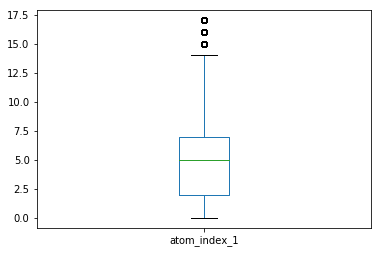

In [21]:
test.loc[test['atom_index_1'] > upper_atom1_test ,'atom_index_1'] = np.median(test['atom_index_1'])
test.loc[test['atom_index_1'] < lower_atom1_test ,'atom_index_1'] = np.median(test['atom_index_1'])
test['atom_index_1'].plot.box()

In [22]:
x_train = train.drop(['id','scalar_coupling_constant'],axis=1)
target = train['scalar_coupling_constant']
x_test = test.drop('id', axis=1)
y_test = sample['scalar_coupling_constant']

In [23]:
x_test.shape, x_train.shape

((2505542, 4), (4658147, 4))

In [24]:
X_train_hash = copy.copy(x_train)
X_test_hash = copy.copy(x_test)
for i in range(X_train_hash.shape[1]):
    X_train_hash.iloc[:,i]=X_train_hash.iloc[:,i].astype('str')
for i in range(X_test_hash.shape[1]):
    X_test_hash.iloc[:,i]=X_test_hash.iloc[:,i].astype('str')

In [25]:
hashing = FeatureHasher(input_type="string")
x_train = hashing.transform(X_train_hash.values)
x_test = hashing.transform(X_test_hash.values)

In [26]:
x_test.shape, x_train.shape

((2505542, 1048576), (4658147, 1048576))

In [27]:
lreg =RandomForestRegressor(max_depth=2)

In [28]:
lreg.fit(x_train, target)
predict_target = lreg.predict(x_test)
lreg.score(x_test, predict_target), lreg.score(x_train, target)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


(1.0, 0.9380056827380655)

In [29]:
predict_target

array([ 1.21001909, 97.32057505,  1.21001909, ...,  1.21001909,
        1.21001909, 97.32057505])

In [30]:
csv = pd.DataFrame()
csv['id'] = test['id']
csv['scalar_coupling_constant'] = predict_target
csv.to_csv('sample_submission.csv', header = True, index= False)